In [1]:
# data preprocessing
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import numpy as np

#viewshed
from uuid import uuid1
from os import makedirs
from affine import Affine
from os.path import exists
from math import exp, hypot
# from time import perf_counter
from rasterio import open as rio_open
from rasterio.transform import rowcol, xy
from skimage.draw import line, disk, circle_perimeter
from numpy import zeros, unique, multiply, array, column_stack
#

# Initial file inspection

In [45]:
# check the metadata, coordinate system and elavation on files
with rasterio.open('DSM_merged.tif') as src:
    print(src.profile)
    print("DSM CRS:", src.crs)
    
    elevation = src.read(1)
    print("Minimum elevation:", elevation.min())
    print("Maximum elevation:", elevation.max())
    print("Mean elevation:", elevation.mean())
    resolution = src.res # resolution
    print("Resolution: {}".format(resolution))
    
    
with rasterio.open('DTM.tif') as src:
    print(src.profile)
    print("DTM CRS:", src.crs)
    
    elevation = src.read(1)
    print("Minimum elevation:", elevation.min())
    print("Maximum elevation:", elevation.max())
    print("Mean elevation:", elevation.mean())
    resolution = src.res # resolution
    print("Resolution: {}".format(resolution))
    
with rasterio.open('20200629_gm_Bomenkaart_v2.tif') as src:
    print(src.profile)
    print("Greeness CRS:", src.crs)
    resolution = src.res # resolution
    print("Resolution: {}".format(resolution))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 43000, 'height': 62500, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(5.0, 0.0, 10000.0,
       0.0, -5.0, 618750.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
DSM CRS: LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Minimum elevation: -12.249995
Maximum elevation: 341.1837
Mean elevation: 3.1893654
Resolution: (5.0, 5.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 43000, 'height': 62500, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(5.0, 0.0, 10000.0,
       0.0, -5.0, 618750.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
DTM CRS: LOCAL_CS["Amersfoort / RD Ne

# Resample Bomenkaart

In [14]:
# resample bomenkaart to 5x5 to match the DSM and DTM
with rasterio.open("20200629_gm_Bomenkaart_v2.tif") as src:
    # Resample to 5x5
    data = src.read(
        out_shape=(
            src.count,
            int(src.height * src.res[0] / 5),
            int(src.width * src.res[1] / 5)
        ),
        resampling=Resampling.bilinear
    )
    # Update the metadata
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    profile = src.profile
    profile.update(transform=transform, width=data.shape[-1], height=data.shape[-2])

    # Save it as a new file
    with rasterio.open("20200629_gm_Bomenkaart_v2_resampled5.tif", "w", **profile) as dst:
        dst.write(data)

In [5]:
# check new resolution
with rasterio.open('20200629_gm_Bomenkaart_v2_resampled.tif') as src:
    resolution = src.res # resolution
    print("Resolution: {}".format(resolution))

Resolution: (5.0, 5.0)


# Sample area to Utrecht

In [39]:
def sample_raster(input_file, output_file, extent):
    """the function samples a large raster file based on a defined
    extend"""
    # Define the polygon based on the given extent
    polygon = Polygon(extent)
    
    with rasterio.open(input_file) as src:
        out_image, out_transform = mask(src, [polygon], crop=True)
        out_meta = src.meta.copy()

    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(out_image)

utrecht_extent = [(110000, 440000), (110000, 480000), (170000, 480000), (170000, 440000), (110000, 440000)]

sample_raster("DSM_merged.tif", "DSM_merged_sample.tif", utrecht_extent)
sample_raster("DTM_sample.tif", "DTM_sample.tif", utrecht_extent)
sample_raster("20200629_gm_Bomenkaart_v2_resampled.tif", "20200629_gm_Bomenkaart_v2_resampled_sample.tif", utrecht_extent)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 12000, 'height': 8000, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(5.0, 0.0, 110000.0,
       0.0, -5.0, 480000.0)}


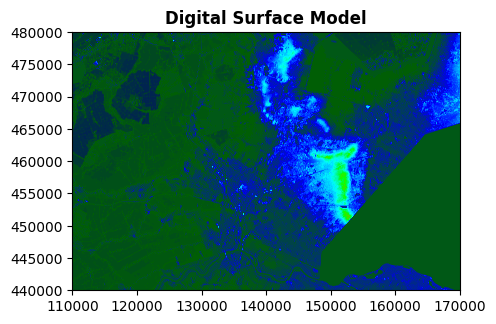

<Axes: title={'center': 'Digital Surface Model'}>

In [41]:
# visualise the sample
dsm = rasterio.open("DSM_merged_sample.tif", driver="GTiff")
print(dsm.meta) # metadata

plt.figure(figsize=(5, 5), dpi=100)  # adjust size and resolution
show(dsm, title='Digital Surface Model', cmap='gist_ncar')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 12000, 'height': 8000, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(5.0, 0.0, 110000.0,
       0.0, -5.0, 480000.0)}


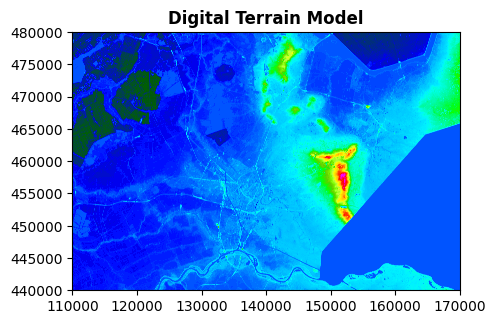

<Axes: title={'center': 'Digital Terrain Model'}>

In [46]:
# visualise the sample
dsm = rasterio.open("DTM_sample.tif", driver="GTiff")
print(dsm.meta) # metadata

plt.figure(figsize=(5, 5), dpi=100)  # adjust size and resolution
show(dsm, title='Digital Terrain Model', cmap='gist_ncar')

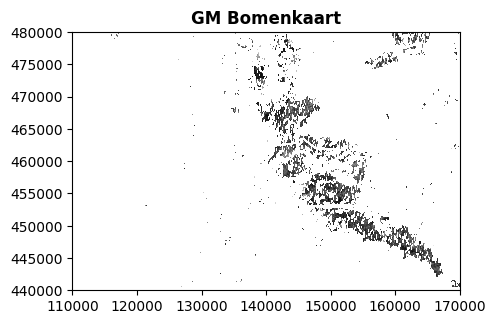

<Axes: title={'center': 'GM Bomenkaart'}>

In [18]:
# visualise the sample
dsm = rasterio.open("20200629_gm_Bomenkaart_v2_resampled_sample.tif", driver="GTiff")

plt.figure(figsize=(5, 5), dpi=100)  # adjust size and resolution
show(dsm, title='GM Bomenkaart', cmap='binary')

# Viewshed analysis

In [19]:
def viewshed(r0, c0, radius_px, resolution, observerHeight, targetHeight, dsm_data, dtm_data, a):
    """
    * Use Bresenham's Circle / Midpoint algorithm to determine endpoints for viewshed
    """

    # create output array at the same dimensions as data for viewshed
    output = zeros(dtm_data.shape)

    # set the start location as visible automatically
    output[(r0, c0)] = 1

    # get pixels in the circle
    for r, c in column_stack(circle_perimeter(r0, c0, radius_px)):

        # calculate line of sight to each pixel
        output = lineOfSight(r0, c0, r, c, resolution, observerHeight, targetHeight, dsm_data, dtm_data, output)

    # return the resulting viewshed
    return output

def lineOfSight(r0, c0, r1, c1, observer_height, resolution, target_height, dsm_data, dtm_data, output):
    """
     * Runs a single ray-trace from one point to another point, returning a list of visible cells
    """

    # init variables for loop
    cur_dydx = 0 		  	# current dydx (base of object)
    max_dydx = 0 	  		# biggest dydx so far
    # top_dydx = 0 		    # current dydx (top of object)
    distance_travelled = 0  # how far we have travelled along the ray

    # get the viewer height
    height0 = dtm_data[(r0, c0)] + observer_height

    # get the pixels in the line (excluding the first one	)
    pixels = column_stack(line(r0, c0, r1, c1))[1:]

    # loop along the pixels in the line
    for r, c in pixels:

        # distance travelled so far
        distance_travelled = hypot(c0 - c, r0 - r)

        ''' comment this out as long as we use 0 as target offset '''
        ## set cell as visible if the height of the top of the object from the DTM > previous max
        # top_dydx = (dsm_data[(r, c)] - height0 + target_height) / distance_travelled
        # if (top_dydx >= max_dydx):
        # 	output[(r, c)] = 1
        #
        ## update max dydx the height of the base of the object on the DSM > previous max
        # cur_dydx = (dsm_data[(r, c)] - height0) / distance_travelled
        # if (cur_dydx > max_dydx):
        # 	max_dydx = cur_dydx

        # update max dydx the height of the base of the object on the DSM > previous max
        cur_dydx = (dsm_data[(r, c)] - height0) / (distance_travelled * resolution)
        if (cur_dydx > max_dydx):
            max_dydx = cur_dydx
            output[(r, c)] = 1

    # return updated output surface
    return output

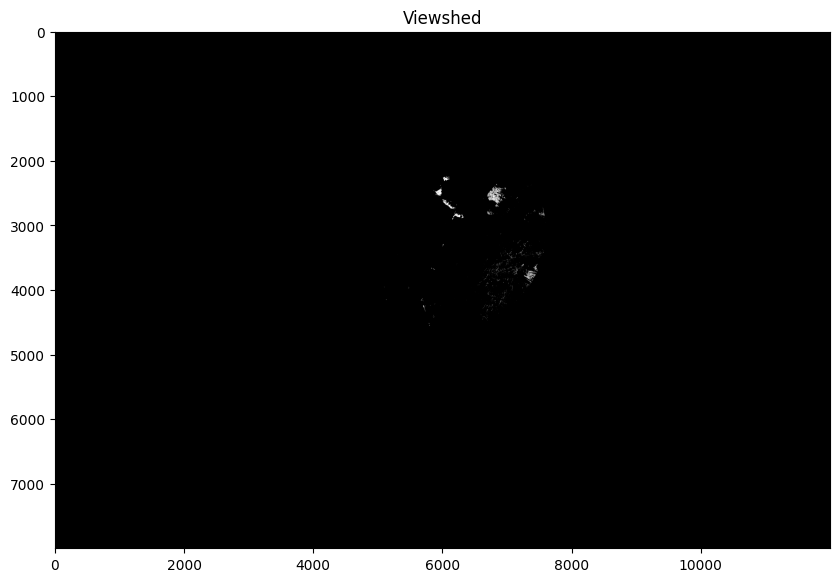

In [20]:
with rasterio.open('DTM_sample.tif') as dsm:
    dsm_data = dsm.read(1)

with rasterio.open('DSM_merged_sample.tif') as dtm:
    dtm_data = dtm.read(1)

# set input parameters
r0 = 3100
c0 = 6100 
radius_px = 1500 
resolution = 5.0 
observerHeight = 2.0 
targetHeight = 0.0 # height of target above the ground in meters
a = 0.13 # coefficient used for adjusting visibility of each cell

output = viewshed(r0, c0, radius_px, resolution, observerHeight, targetHeight, dsm_data, dtm_data, a)

# convert boolean array to numeric array of 0s and 1s
output = output.astype(np.uint8)

# visualise the viewshed
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(output, cmap='gray')
ax.set_title('Viewshed')
plt.show()